name: Marco Giunta

In [2]:
library("tidyverse")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# Exercise 1: the triangular distribution
Our function is parametrized by three numbers $a \leq c \leq b$ and defined as:
\begin{equation}
  f(x) =
    \left\{
      \begin{array}
        \ \frac{2(x-a)}{(b-a)(c-a)} \ a\leq x < c \\
        \ \frac{2(b-x)}{(b-a)(b-c)} \ c\leq x \leq b\\
        \ \ 0 \qquad \text{otherwise}
      \end{array}
    \right.
\end{equation}
This is easily implemented with a nested `ifelse`.

In [1]:
dtriang <- function(x, a, b, c, log = FALSE) {
    y <- ifelse((a <= x & x < c), 2*(x-a)/((b-a)*(c-a)), ifelse((c <= x & x <= b), 2*(b-x)/((b-a)*(b-c)), 0))
    if (log) y <- log(y)
    return(y)
}

## 1.1: function plot
If we choose 3 values for $a$, $b$ and $c$ we can easily plot our function.

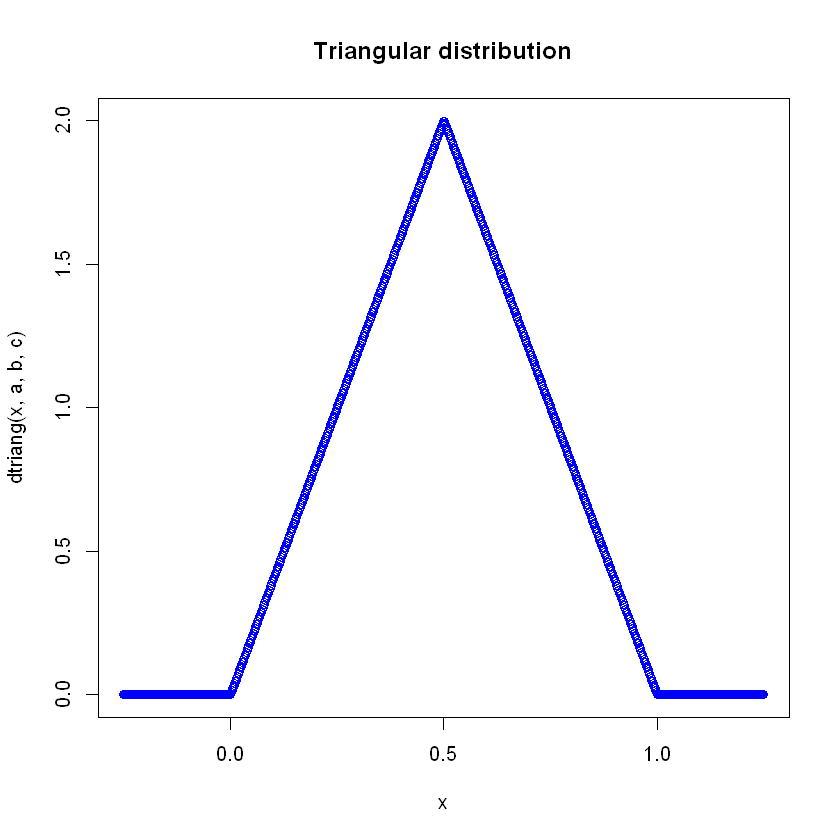

In [10]:
# we pick a = 0, c = 0.5, b = 1 for simplicity.
a <- 0; b <- 1; c <- 0.5
x <- seq(a-0.25, b+0.25, length.out = 1000) # we include extra values to check it's zero outside [a,b]=[0,1]
plot(x, dtriang(x, a, b, c), col = "blue", main = "Triangular distribution")

## 1.2: Sampling from the triangular distribution
### Inverse transform sampling
As we know a simple algorithm to sample from an arbitrary distribution is via *inverse transform sampling*, which consists in applying the inverse CDF to random numbers sampled from $U[0,1]$; the difficult part is evaluating
the inverse CDF, which in the simple case of a triangular distribution can actually be computed exactly.          
We start by computing the CDF via its integral definition:
\begin{equation}
F(x) = \int_{-\infty}^x f(x') \ \mathrm{d} x'
\end{equation}
This integral can be evaluated numerically, but since later we'll need to make many calls to the cdf it's best not to be lazy and analitically integrate $f$ (which isn't very hard, since it's just a polynomial); otherwise everything will be uncecessarily slow.                 
It's possible to show that the CDF $F(x)$ is:
\begin{equation}
  F(x)=
    \left\{
      \begin{array}
       \ 0 \qquad \qquad \qquad \qquad x \leq a\\ 
       \ \frac{(x-a)^2}{(b-a)(c-a)} \qquad \qquad a \leq x \leq c \\
       \ \frac{(b-c)^2-(b-x)^2}{(b-a)(b-c)} + \frac{c-a}{b-a} \ \ c \leq x \leq b \\ 
       \ 1 \qquad \qquad \qquad \qquad x \geq b
      \end{array}
    \right.
\end{equation}
Notice that we can use $\leq$ everywhere with no need to distinguish where to include, say, $c$. This is true because since $f$ is continuous (even though not differentiable) and $F'(x)=f(x)$ by definition then it means that 
$F$ is both continuous and differentiable, and hence it must be possible to smoothly join the different parts of the curve (and even if we didn't consider this fact it's trivial to check continuity of the above function since limits of 
polynomials are trivial).

In [ ]:
# Function definition
ptriang <- function(x, a, b, c, lower.tail = TRUE, log.p = FALSE) {
    y <- ifelse((x <= a), 0, ifelse((x >= b), 1, ifelse((x < c), (x-a)^2/((b-a)*(c-a)), ((b-c)^2-(b-x)^2)/((b-a)*(b-c)) + (c-a)/(b-a)))) 
    # Note that if x is less than a the integral is trivially 0; similarly due to normaliz. it's 1 if x is greater than b.
    # If neither of these holds then x is definitely in [a,b], and we only need to check whether it's less or greater than c.
                   
    if (lower.tail == FALSE) {y <- 1 - y}
    if (log.p) {y <- log(y)}
    return(y)    
}

In [11]:
# CDF definition
# Note: usually I use ifelse in place of if to achieve vectorization, but since we have to define many cases I find it easier to type a function with many if and else's capable of accepting scalars only and then apply Vectorize
ptriang <- function(x, a, b, c, lower.tail = TRUE, log.p = FALSE) {
    # Note that if x is less than a the integral is trivially 0; similarly due to normaliz. it's 1 if x is greater than b.
    # If neither of these holds then x is definitely in [a,b], and we only need to check whether it's less or greater than c.
    if(x <= a) y <- 0
    else {
        if(x >= b) y <- 1
        else {
            if(x < c) y <- (x-a)^2/((b-a)*(c-a))
            else y <- ((b-c)^2-(b-x)^2)/((b-a)*(b-c)) + (c-a)/(b-a)
        }
    }
    if (lower.tail == FALSE) {y <- 1 - y}
    if (log.p) {y <- log(y)}
    return(y)    
}

ptriang <- Vectorize(ptriang)

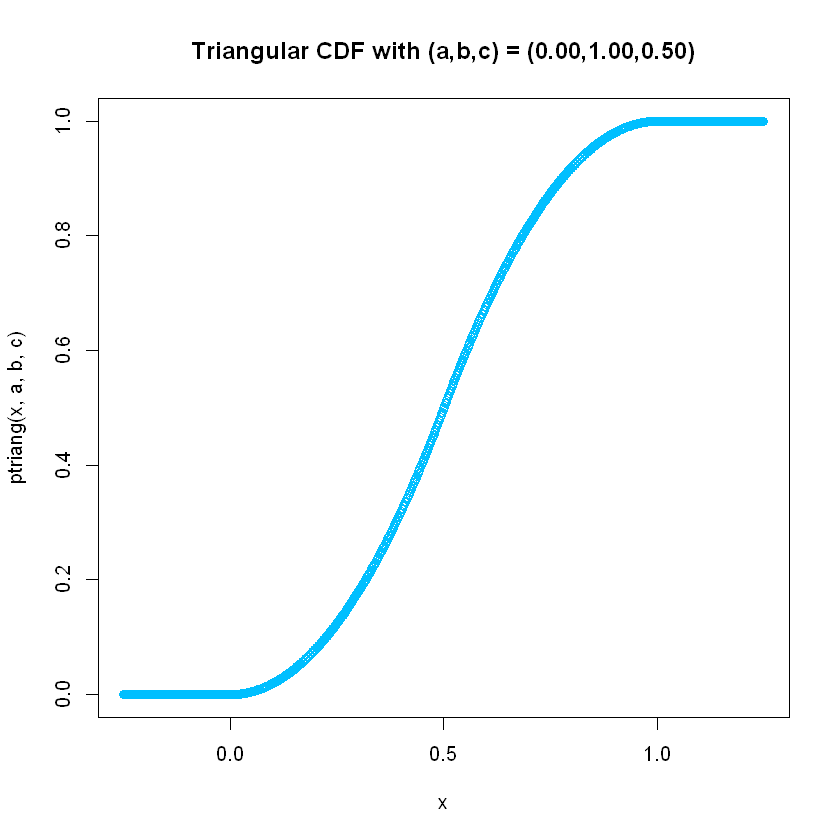

In [37]:
# CDF Plot to check its shape
# we pick a = 0, c = 0.5, b = 1 for simplicity.
a <- 0; b <- 1; c <- 0.5
x <- seq(a-0.25, b+0.25, length.out = 1000) # we include extra values to check it's zero outside [a,b]=[0,1]
plot(x, ptriang(x, a, b, c), col = "deepskyblue", main = sprintf("Triangular CDF with (a,b,c) = (%.2f,%.2f,%.2f)", a, b, c))

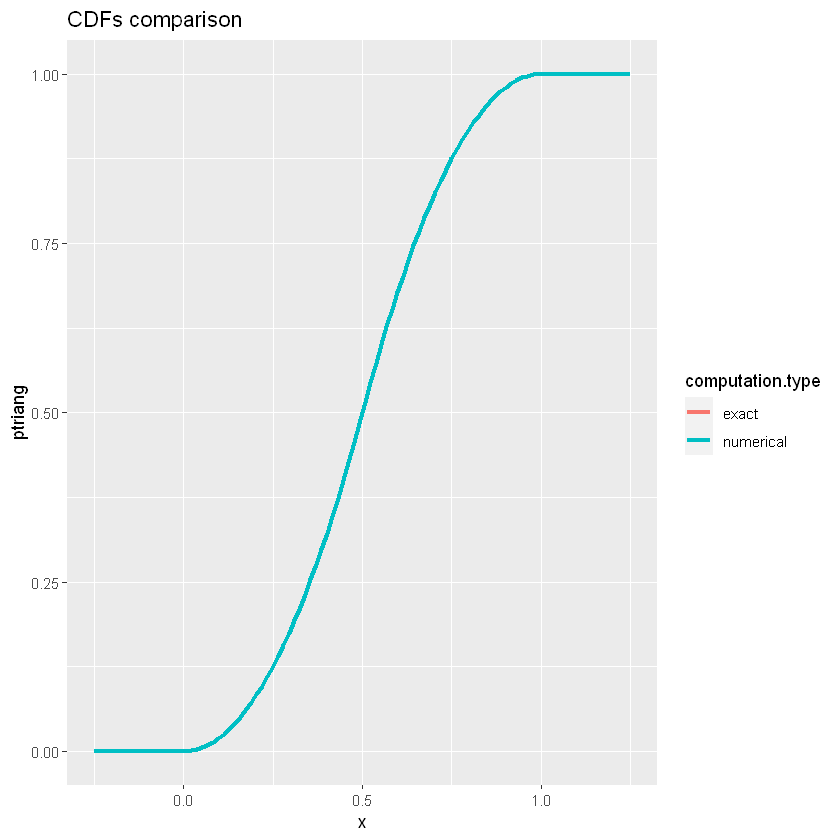

In [39]:
# To check everything works we compare the exact CDF with the one we can define via numerical integration as follows.
ptriang.numerical <- function(x, a, b, c, lower.tail = TRUE, log.p = FALSE) {
    f <- function(z) dtriang(z, a, b, c)
    
    # We apply Vectorize to a function which returns integrate's output, then evaluate the resulting function inside the ifelse
    g <- Vectorize(function(z) integrate(f, a, z)$value) # it's enough to integrate "above" a since "below" a f is zero
                   
    y <- ifelse((x <= a), 0, ifelse((x >= b), 1, g(x))) # if x is less than a the integral is trivially 0; similarly due to normaliz. it's 1 if x is greater than b. Only in between do we actually need to compute an integral
    # Technically the above step is not needed (we could just compute the integral for arbitrary x), but since this is just an approximation it's best to avoid it when the exact result is easily available;
    # this way we both reduce numerical errors and speed up the computation of the function (when possible we exchange the computation of an integral with the function just returning a constant)
                   
    if (lower.tail == FALSE) {y <- 1 - y}
    if (log.p) {y <- log(y)}
    return(y)    
}
                   
# Now we plot both of them via ggplot to check they produce indistinguishable curves.
# we pick a = 0, c = 0.5, b = 1 for simplicity.
a <- 0; b <- 1; c <- 0.5
N <- 100 # numbers of points to compute
x <- seq(a-0.25, b+0.25, length.out = N) # we include extra values to check it's zero outside [a,b]=[0,1]
y <- c(ptriang(x, a, b, c), ptriang.numerical(x, a, b, c))
computation.type <- c(rep("exact", times = N), rep("numerical", times = N))
df <- data.frame(x, y, type)
names(df) <- c("x", "ptriang", "computation type")
g <- ggplot(data = df) + geom_line(aes(x = x, y = ptriang, col = computation.type), size = 1.2) + ggtitle("CDFs comparison")
g # they definitely are the same function!

Now that we have the CDF we can invert it and apply its inverse to uniform random numbers as explained above; the only things that remains to do is to numerically invert the cdf.

In [40]:
# (the following explanation of how I perform the numerical inversion of a monotonically increasing function with codomain = [0,1] has been copied and pasted from my previous homework)

qtriang <- function(y, a, b, c, lower.tail = TRUE, log.p = FALSE) {
    # by definition the quantile function Q(y) associated to the cdf F(x) returns the particular value of x such that F(x)=y; if F is a stricly monotonically increasing function then it holds that Q = F^-1.
    # Since by definition the cdf returns a probability it must always hold that F maps its domain to the interval [0,1], and hence the quantile's domanin must be [0,1], too, and because of this we define qexamtime in
    # such a way that it returns NA if the user tries to input a number not in [0,1].
    
    # Let's now say our user has inputted a number y in [0,1]; how do we compute Q(y)? If the cdf was a simpler function then we could compute its inverse analitically by solving the equation F(x) = y i.e.
    # by inverting F exactly, but this isn't practical in our case. We already know our F(x) is a 3rd degree polynomial, and hence F(x) = y can technically be solved exactly - but with a complex formula! Even if we use 
    # numerical root finding routines we have the issue that the three roots are real and therefore we'd have to choose one.
    # Because of this we turn towards a general method to numerically invert a monotonic function and proceed as follows.
    
    # Our task is to invert the function F(x) i.e. to solve the equation F(x) = y, which is equivalent to F(x)-y = 0. If we discretize our input values we can define a vector X, which represents every possible discrete input
    # to be fed to F; this lets us immediately compute the vector Y holding the images of our discretized domain (trivial if the implementation of F is vectorized). Let's now say that we want to find which x in X was used
    # to generate a certain y in Y; the x we're looking for is the one which solves F(x)-y=0, i.e. the component of F(X)-y which is closest to 0 (since by definition x's image is equal to y; we consider "closest" instead of "equal"
    # to account for numerical errors). If F is monotonic then the solution to this equation is actually unique, because in order to find multiple x's with the same images our function would either need to be constant or
    # to have a derivative with variable sign (neither of which is true for our cdf in its nontrivial interval).
    # Our numerical inversion algorithm is hence as follows: 
    # - if the user input is not in ]0,1[ we return NA (0 ad 1 are not included because any x outside ]1,2[ has 0 or 1 as image, hence F is not invertible there). Otherwise:
    # - we generate a grid X of interisting x values (i.e. between 1 and 2);
    # - we compute the argmin of |F(X)-y| for user input y (via which.min);
    # - we return the component of X of index equal to the above argmin.
    
    X <- seq(a, b, length.out = 1e4) # finer grid divisions may be chosen. Notice that we care about the generic [a,b] interval; outside of it f = 0 and the cdf is piecewise constant and hence not invertible
    x <- ifelse((0 < y & y < 1), X[which.min(abs(ptriang(X, a, b, c,)-y))], NA)
    if (lower.tail == FALSE) x <- 1-x
    if (log.p) x <- log(x)
    return(x)
}

# The above function is not vectorized and instead returns a constant vector of the x associated to the last component of the input (I'm not sure why); to fix this we use the Vectorize function.
qtriang <- Vectorize(qtriang)
# an alternative is to use something like map_dbl(x, qtriang)

# random variate sampler via inverse transform sampling
rtriang <- function(n, a, b, c) return(qtriang(runif(n), a, b, c)) # here we need qtriang to be fully vectorized!

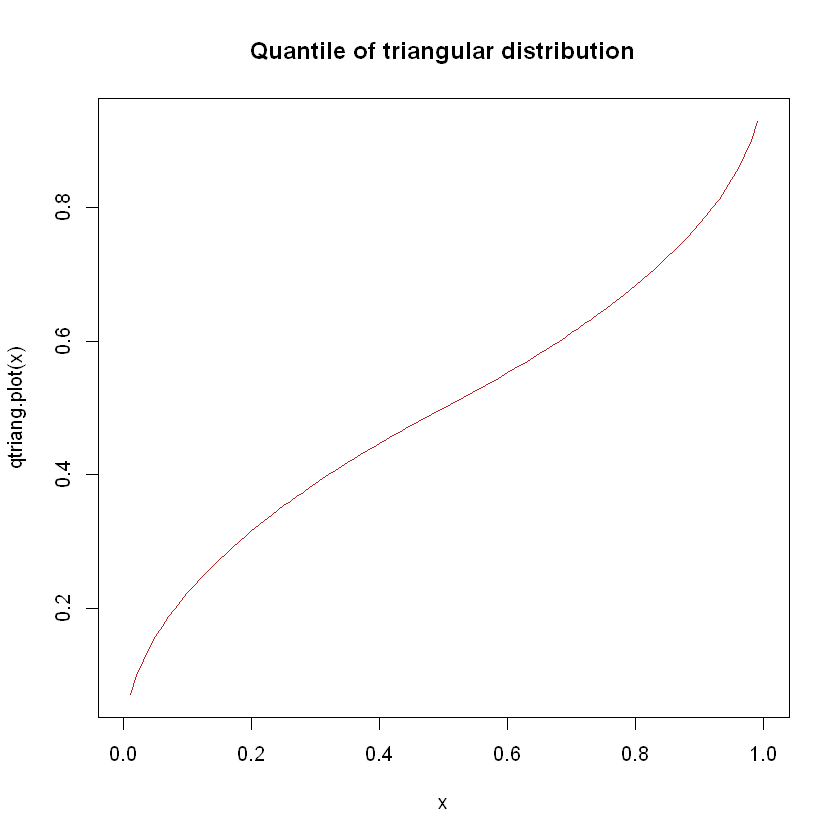

In [44]:
# Quantile function plot
a <- 0; b <- 1; c <- 0.5
qtriang.plot <- function(x) qtriang(x, a, b, c) # we fix the parameters in order to have a function of x only
curve(qtriang.plot, col = "firebrick", main = "Quantile of triangular distribution") # This way we evaluate the quantile over n = 101 points (default value) between 0 and 1 (default values, exactly what we need)

### Accept-reject Montecarlo sampling

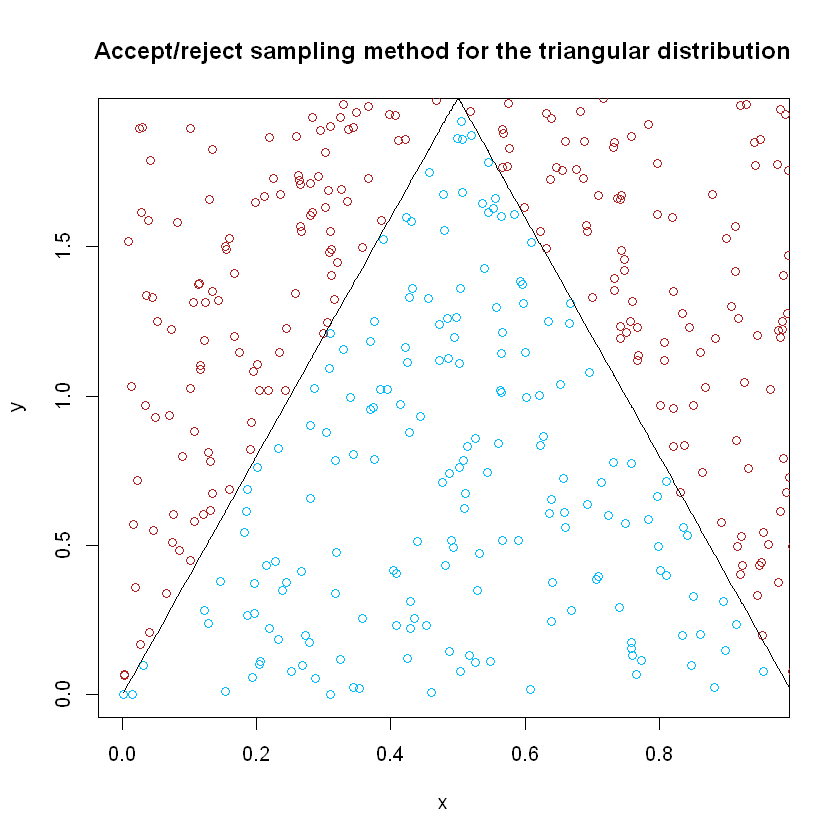

In [42]:
set.seed(1234)
# Parameters
a <- 0; b <- 1; c <- 0.5
n <- 400

# Simulated points
x <- runif(n, min = a, max = b)
y <- runif(n, min = 0, max = dtriang(c, a, b, c))

# Divisions of points into the three different sets we want to plot
y.triang <- dtriang(x, a, b, c)
ind <- y < y.triang

x.accept <- x[ind]
y.accept <- y[ind]

x.reject <- x[!ind]
y.reject <- y[!ind]

x.sorted <- sort(x, index.return = TRUE)
x.triang <- x.sorted$x # to plot a solid line for the pdf we need to sort our points along the x axis, otherwise the lines function will connect them as they are in the array (i.e. at random)
y.triang <- y.triang[x.sorted$ix]

# Plot
plot(x.accept, y.accept, col = "deepskyblue", main = "Accept/reject sampling method for the triangular distribution", xlab = "x", ylab = "y")
points(x.reject, y.reject, col = "firebrick")
lines(x.triang, y.triang, col = "black")
#plot(runif(n, min = a, max = b), runif(n, min = 0, max = dtriang(c, a, b, c)))
#dtriang.plot <- function (x) dtriang(x, a, b, c)
#curve(dtriang.plot, from = a, to = b, add = TRUE)

In [26]:
a <- 0; b <- 1; c <- 0.5

rtriang.ar <- function(n, a, b, c) {
    x <- runif(n, min = a, max = b) 
    y1 <- runif(n, min = 0, max = dtriang(c, a, b, c))
    y2 <- dtriang(x, a, b, c)
    x.accepted <- x[y1 < y2]
    return(x.accepted)
}

rtriang.ar.n <- function(n, a, b, c) {
    x.accepted <- rtriang.ar(n, a, b, c)
    while(length(x.accepted) < n) x.accepted <- c(x.accepted, rtriang.ar(n, a, b, c))
    return(x.accepted[1:n])
}

set.seed(1234)
v <- rtriang.ar.n(1e4, a, b, c)
length(v)

[1] 10000

## 1.3: Comparison between the sampled population and the PDF
Now we can actually sample a bunch of points from the triangular distribution; to do so we call the `rtriang` function, then we plot an histogram of them and superimpose the pdf made with the `dtriang` function.

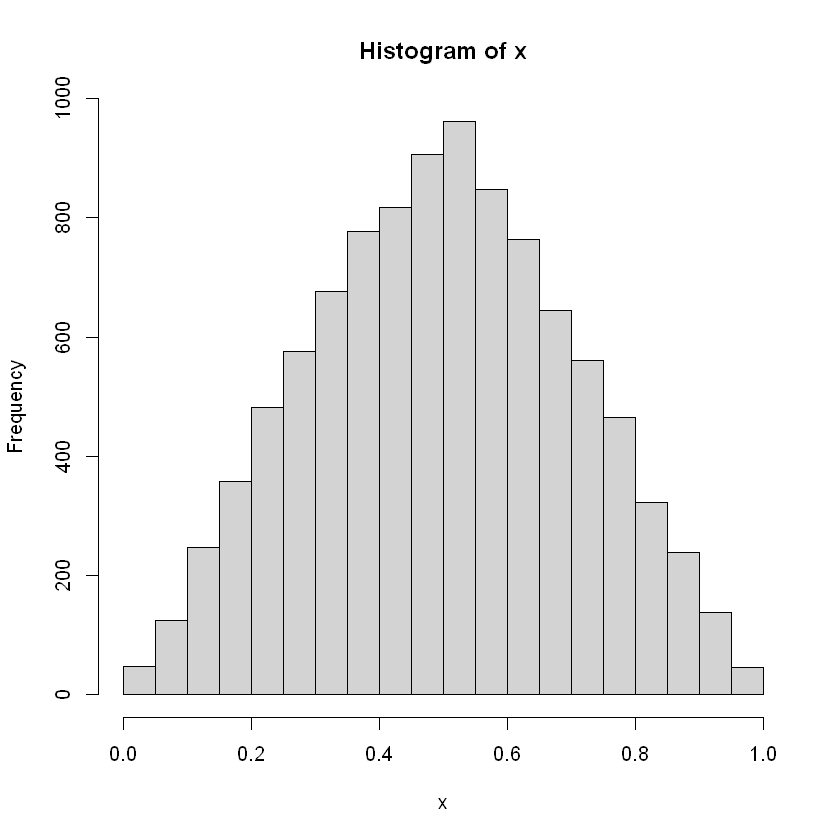

In [50]:
N <- 1e4 # points to sample from the distribution. Our implementation is somewhat slow, so we need to be careful with how large N is!
# we pick a = 0, c = 0.5, b = 1 for simplicity.
a <- 0; b <- 1; c <- 0.5
x <- rtriang(N, a, b, c)
hist(x)

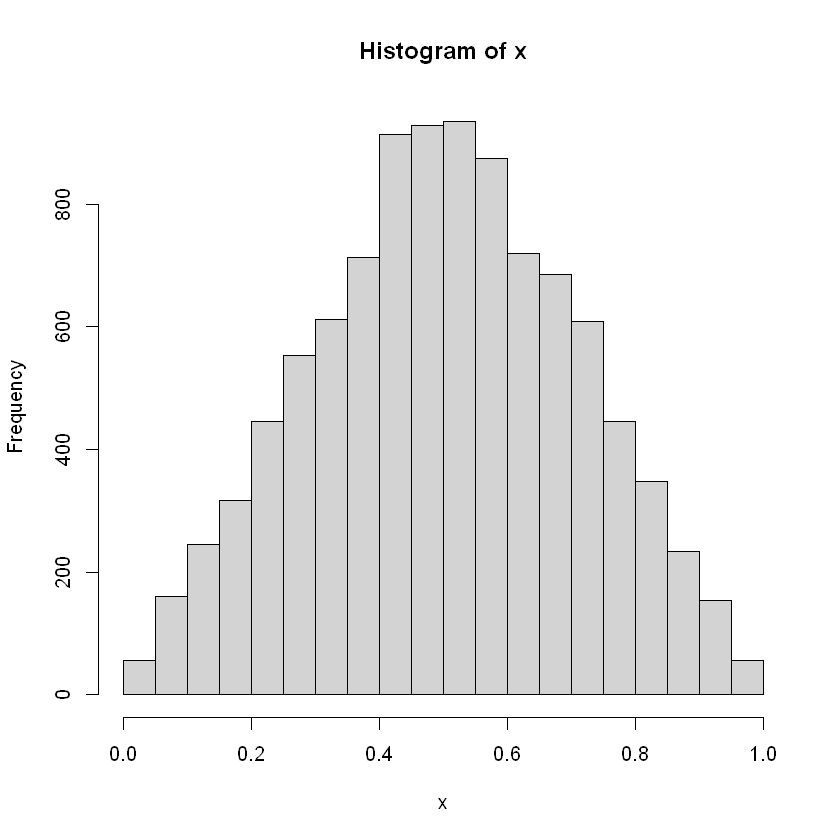

In [27]:
N <- 1e4 # points to sample from the distribution. Our implementation is somewhat slow, so we need to be careful with how large N is!
# we pick a = 0, c = 0.5, b = 1 for simplicity.
a <- 0; b <- 1; c <- 0.5
x <- rtriang.ar.n(N, a, b, c)
hist(x)

In [18]:
length(dtriang(1:n, a, b, c))

[1] 100

# Exercise 2: Markov's inequality

# Exercise 3: Chebyshev's inequality

# Exercise 4: Community mobility open data